# /image/*.png と /Label/*.png を使って衣服検出


## 1. import

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## 2. Configuration(訓練の為の設定)

In [2]:
class ClothConfig(Config):

    
    def __init__(self):
        """Set values of computed attributes."""
        # Effective batch size
        self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

        # Input image size
        #self.IMAGE_SHAPE = np.array(
        #    [self.IMAGE_MIN_DIM, self.IMAGE_MAX_DIM, 3]) #changed 02/27
        self.IMAGE_SHAPE = np.array(
            [self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM, 3])
        
        
        # Compute backbone size from input image size
        self.BACKBONE_SHAPES = np.array(
            [[int(math.ceil(self.IMAGE_SHAPE[0] / stride)),
              int(math.ceil(self.IMAGE_SHAPE[1] / stride))]
             for stride in self.BACKBONE_STRIDES])
    
    
    # Give the configuration a recognizable name
    NAME = "clothes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256#320
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 10

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ClothConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           clothes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI

# 3. モデル生成と訓練済みの重みをLoad

In [3]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# 以前学習した重みをロード
ROOT_DIR = os.getcwd()
model_path = [ROOT_DIR, "mask_rcnn_clothes_0250.h5"]
model_path = os.path.join(*model_path)
model.load_weights(model_path, by_name=True)

"""
# 重みをload

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
"""

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


'\n# 重みをload\n\n# Which weights to start with?\ninit_with = "coco"  # imagenet, coco, or last\n\nif init_with == "imagenet":\n    model.load_weights(model.get_imagenet_weights(), by_name=True)\nelif init_with == "coco":\n    # Load weights trained on MS COCO, but skip layers that\n    # are different due to the different number of classes\n    # See README for instructions to download the COCO weights\n    model.load_weights(COCO_MODEL_PATH, by_name=True,\n                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", \n                                "mrcnn_bbox", "mrcnn_mask"])\nelif init_with == "last":\n    # Load the last model you trained and continue training\n    model.load_weights(model.find_last()[1], by_name=True)\n'

## 4. データセットの設定

画像/ラベルデータの例.
label <class 'numpy.ndarray'> [130  69  17]


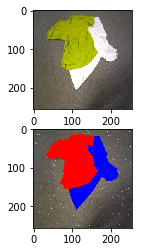

(データ数, H, W, RGBの3) =  (100, 256, 256, 3)


In [4]:
#画像データはarray型にする。
import cv2

#pngデータ読込
image_num = 100
images = []
labels = []

size_tmp = 256, 256

print("画像/ラベルデータの例.")
img = cv2.imread("./train/0_ex1.png")
img = cv2.resize(img, size_tmp)
label = cv2.imread("./Label/0_ex1_label.png")
label = cv2.resize(label, size_tmp)
print("label", type(label[0][0]), label[0][0])
plt.subplot(211)
plt.imshow(img[:,:,::-1])

#上のconfigの都合上とりあえずリサイズする。そのため

plt.subplot(212)
plt.imshow(label[:,:,::-1])
plt.show()

for i in range(image_num):
    try:
        #画像読込
        img_name = "./image/" + str(i) + "_ex1.png"
        img = cv2.imread(img_name)
        img = cv2.resize(img,(256,256))
        images.append(img)
        #ラベル画像読込
        label_name = "./Label/" + str(i) + "_ex1_label.png"
        label = cv2.imread(label_name)
        label = cv2.resize(label, (256,256))
        labels.append(label)
        
    except:
        print("Error. No such file or directory: " + img_name)
        print("Error. No such file or directory: " + label_name)



dataset_train = np.array(images)
print("(データ数, H, W, RGBの3) = ", dataset_train.shape)

### Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### 4.5 データセットの型を整える

In [10]:
num_train = 400
num_test = 99

class ClothesDataset(utils.Dataset):
    
    
    def load_clothes(self, count, width, height, flag):
        #classを追加
        
        import json
        from statistics import mean, median,variance,stdev
        #self.add_class("clothes",0,"BG") #いらない！！！！ 180710 by pancho
        self.add_class("clothes",1,"tg")
        self.add_class("clothes",2,"tw") 
        #self.add_class("clothes",3,"BG")
        bg_color = [255, 255, 255]
        
        print("count", count)
        
        for i in range(count): #衣服画像の枚数だけ繰り返す
            
        #1. クラスラベルの情報(位置、色情報など)をshapesに格納し、 
            shapes = []
            if(flag == 1):
                ID = i + num_train #連番の最後の方をテスト用にしているので 0301 pancho
            else: ID = i
            
            if(flag == 0):
                json_name = "./train2/" + str(ID) + "_ex1.json"
            else: json_name = "./test2/" + str(ID) + "_ex1.json"
            
            f = open(json_name)
            data = json.load(f)
            json_label_num = len(data["shapes"]) #num pf shapes on each image
            #json_label_num = 2 # num of Instance on each Image 180711 2 {tg,tw}
            instanceNum = 2 # it means json_label_num


            #points=[]
            labels = ['tw', 'tg']
            dic = {"tw":None,"tg":None}
            for j in labels:
                tmp = []
                for k in range(json_label_num):
                    if j == data["shapes"][k]["label"]:
                        tmp.append(k)
                dic[j] = tmp

            for j in labels:
                RB = [] #right bottom
                LU = [] #left up
                for k in dic[j]:
                    points = np.array(data["shapes"][k]["points"])

                    right = max(points[:,0])
                    left = min(points[:,0])
                    up = min(points[:,1])
                    bottom = max(points[:,1])

                    RB.append([right,bottom])

                    LU.append([left,up])

                RB = np.array(RB)
                LU = np.array(LU)

                rb = [RB[:,0].max(),RB[:,1].max()]
                lu = [LU[:,0].min(),LU[:,1].min()]

                x_width = (rb[0] - lu[0]) / 2
                y_width = (rb[1] - lu[1]) / 2 

                if(x_width > y_width):
                    size = int(x_width+10) 
                else: 
                    size = int(y_width+10)

                
                
                if(j =="tg"):#green Tshirts
                    color = (255,0,0) # RED for tg
                elif(j == "tw"): 
                    color = (0,0,255) #BLUE for tw
                else: print("ERROR. the object has no class id like \"tg\"")    
                    
                
                x_center = int(x_width)
                y_center = int(y_width)
                
                data_to_shapes = (j, color, (x_center, y_center, size))
                
                shapes.append(data_to_shapes)
            
            if ID >= 90:
                path = "./test/" + str(ID) + "_ex1.png"     
            else:
                path = "./train/" + str(ID) + "_ex1.png"  
            
            #print("load_clothes. id. ", i)
            
            self.add_image("clothes", image_id = ID, path = path,
                            width = width, height = height,
                            bg_color = bg_color, clothes = shapes)
           

    def load_image (self, image_id):
        width = 256
        height = 256
        test_start_id = 90
        
        info = self.image_info[image_id]
        
        print("image_id in [load_image].", image_id)
        if image_id >= test_start_id: #90番目以降はテスト用
            img_name = "./test/" + str(image_id) + "_ex1.png"
        else:
            img_name =  "./train/" + str(image_id) + "_ex1.png"
        
        image = cv2.imread(img_name)
   
        image = cv2.resize(image,(width,height))
        return image[:,:,::-1]
        
    
        
        
            
    def image_reference(self, image_id):
        info = self.image_info[image_id] 
        if info["source"] == "clothes":
            return info["clothes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    
    def load_mask(self, image_id):
        """
        データセットによってmaskを格納する方法は異なる。
        
        戻り値(2つ). 
            mask (numpy array型)
                インスタンス毎に1つのmaskを用意し、その配列として返す
            class_ids.(numpy adday型)
                画像中のインスタンス毎にIDを付与し、それを1D配列として格納したもの。
        
        """
        
        info = self.image_info[image_id] #image_idに関する各種情報を取ってくる。
        shapes = info['clothes']
        width = info["width"]
        height = info["height"]
        print("image_id", image_id)
        print("shapes", shapes)
        #count = len(shapes)  #背景を除くインスタンスの数 len(shapes)にしたらオブジェクトが3個以上になるので
        count = 2 #とりあえず全画像のインスタンス数は2なので、とりあえず2で固定。 180711
        
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
       
        print("enter_mask _R-CNN")
        #class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        class_ids = np.array([1,2])
        print("class_ids. (",image_id ,")",class_ids)
        """
        色付けしたラベル画像をみていく。
        もし色が赤、あるいは青であれば、
            mask[i][j]["対応するクラス番号. tgなら1なので0(サイズ2なので)"] = 255
            mask[i][j]["上以外の番号.今回は2つだけなので余った1つ"] = 0
        
        """
        label_name = "./Label/" + str(image_id) + "_ex1_label.png"
        
        label_img = cv2.imread(label_name)
        
        label_img = cv2.resize(label_img,(width,height))
        
        print("width", width)
        print("height", height)
        
        
        #print("shapesの1つめのインスタンス", shapes[0][0])
        
        #mask付やりなおし 180710 by pancho
        
        for i in range(width):
            for j in range(height):
                if np.allclose(label_img[i][j], np.array([0,0,255])): #赤色のところはラベル付したところとみなす
                    #place = np.array([i,j])
                    #mask[i][j] = self.getInstance(shapes, place,"tg")
                    mask[i][j][0] = 255
                    mask[i][j][1] = 1
                elif np.allclose(label_img[i][j], np.array([255,0,0])):#Tshirts White
                    #place = np.array([i,j])
                    #mask[i][j] = self.getInstance(shapes, place,"tw")
                    mask[i][j][0] = 1
                    mask[i][j][1] = 255
        
        
        #for Debug if exsist "0" data in mask or not.
        print("(load_mask)mask.shape", mask.shape)
        
        #print("class_ids", class_ids)
        return mask, class_ids.astype(np.int32)

In [11]:
#Training dataset
train_num = 400
test_num = 99

flag = {"train": 0,"test":1}

dataset_train = ClothesDataset()
dataset_train.load_clothes(90, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], flag["train"])
dataset_train.prepare()

# Validation dataset
dataset_val = ClothesDataset()
dataset_val.load_clothes(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], flag["test"])
dataset_val.prepare()



count 90
count 10


In [12]:
dataset_train.class_ids

array([0, 1, 2])

class_id 1:green Tshirt
class_id 2:white Tshirt

dataset_train.class_names ['BG', 'tg', 'tw']
iamge_ids [87 81 56 60]
image_id in [load_image]. 87
image_id 87
shapes [('tw', (0, 0, 255), (99, 85, 109)), ('tg', (255, 0, 0), (93, 81, 103))]
enter_mask _R-CNN
class_ids. ( 87 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
!!mask.shape (256, 256, 2)
!!class_ids [1 2]


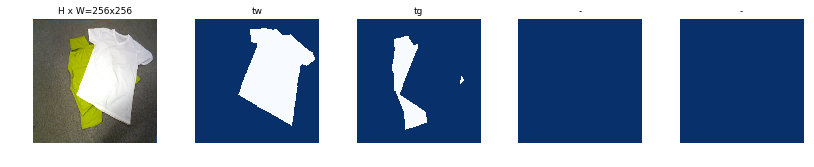

image_id in [load_image]. 81
image_id 81
shapes [('tw', (0, 0, 255), (84, 71, 94)), ('tg', (255, 0, 0), (83, 87, 97))]
enter_mask _R-CNN
class_ids. ( 81 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
!!mask.shape (256, 256, 2)
!!class_ids [1 2]


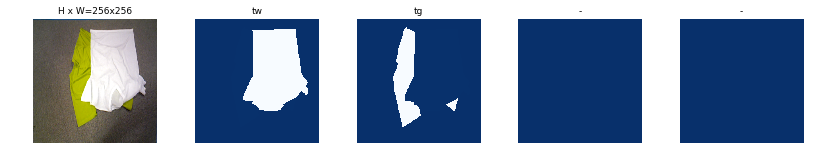

image_id in [load_image]. 56
image_id 56
shapes [('tw', (0, 0, 255), (83, 67, 93)), ('tg', (255, 0, 0), (94, 82, 104))]
enter_mask _R-CNN
class_ids. ( 56 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
!!mask.shape (256, 256, 2)
!!class_ids [1 2]


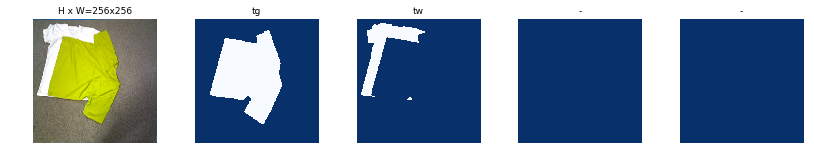

image_id in [load_image]. 60
image_id 60
shapes [('tw', (0, 0, 255), (78, 69, 88)), ('tg', (255, 0, 0), (97, 68, 107))]
enter_mask _R-CNN
class_ids. ( 60 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
!!mask.shape (256, 256, 2)
!!class_ids [1 2]


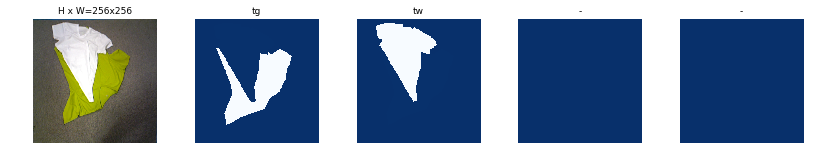

In [13]:
# Load and display random samples
print("class_id 1:green Tshirt")
print("class_id 2:white Tshirt\n")
print("dataset_train.class_names",dataset_train.class_names)

image_ids = np.random.choice(dataset_train.image_ids, 4)
print("iamge_ids",image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    #print("image.shape",image.shape)
    print("!!mask.shape",mask.shape)
    #print("!!mask",mask)
    print("!!class_ids",class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [22]:
mask = dataset_train.lad_mask(0)
print("load_mask[0]:", mask)

image_id 0
shapes [('tw', (0, 0, 255), (79, 80, 90)), ('tg', (255, 0, 0), (85, 61, 95))]
enter_mask _R-CNN
class_ids. ( 0 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
load_mask[0]: (array([[[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       ...,

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]]], dtype=uint8), array([1, 2], dtype=int32))


# 5. ラベル設定

In [14]:
#BG.back ground, tg. Tshirts Green, Tshirts White
#class_names = ["BG", "tg", "tw"]
class_names = ["tg", "tw"]

In [15]:
dataset_train.sources

['', 'clothes']

# 6. 訓練

In [4]:
# # Training - Stage 1
# print("Training network heads")
# model.train(dataset_train, dataset_val,
#             learning_rate=config.LEARNING_RATE,
#             epochs=1,
#             layers='heads')

In [13]:
# # Training - Stage 2
# # Finetune layers from ResNet stage 4 and up
# print("Fine tune Resnet stage 4 and up")
# model.train(dataset_train, dataset_val,
#             learning_rate=config.LEARNING_RATE,
#             epochs=1,
#             layers='4+')

Fine tune Resnet stage 4 and up

Starting at epoch 1. LR=0.001

Checkpoint Path: /home/pancho_learning/code_MaskR-CNN/logs/clothes20180711T1939/mask_rcnn_clothes_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (Batc

(load_mask)mask.shape (256, 256, 2)


/home/pancho_learning/.pyenv/versions/anaconda3-5.0.1/envs/MaskR-CNN/lib/python3.4/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/pancho_learning/.pyenv/versions/anaconda3-5.0.1/envs/MaskR-CNN/lib/python3.4/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


image_id in [load_image]. 70
image_id 70
shapes [('tw', (0, 0, 255), (100, 74, 110)), ('tg', (255, 0, 0), (91, 88, 101))]
image_id in [load_image]. 30
class_ids. ( 70 ) [1 2]
enter_mask _R-CNN
image_id 30
width 256
image_id in [load_image]. 34


In [38]:
# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=1,
            layers='all')

Fine tune all layers

Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/pancho_learning/code_MaskR-CNN/logs/clothes20180720T1732/mask_rcnn_clothes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res

image_id in [load_image]. 9
image_id 9
shapes [('tw', (0, 0, 255), (69, 86, 96)), ('tg', (255, 0, 0), (106, 93, 116))]
enter_mask _R-CNN
class_ids. ( 9 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 8
image_id 8
shapes [('tw', (0, 0, 255), (96, 85, 106)), ('tg', (255, 0, 0), (92, 69, 102))]
enter_mask _R-CNN
class_ids. ( 8 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 6
image_id 6
shapes [('tw', (0, 0, 255), (99, 85, 109)), ('tg', (255, 0, 0), (94, 68, 104))]
enter_mask _R-CNN
class_ids. ( 6 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 5
image_id 5
shapes [('tw', (0, 0, 255), (95, 74, 105)), ('tg', (255, 0, 0), (82, 67, 92))]
enter_mask _R-CNN
class_ids. ( 5 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 4
image_id 4
shapes [('tw', (0, 0, 255), (95, 73, 105)), ('tg', (255, 0, 0), (83, 67, 93))]
enter_mask _R-C

/home/pancho_learning/.pyenv/versions/anaconda3-5.0.1/envs/MaskR-CNN/lib/python3.4/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/pancho_learning/.pyenv/versions/anaconda3-5.0.1/envs/MaskR-CNN/lib/python3.4/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


image_id in [load_image]. 38
image_id in [load_image]. 35
shapes [('tw', (0, 0, 255), (65, 77, 87)), ('tg', (255, 0, 0), (84, 63, 94))]
image_id 38
enter_mask _R-CNN
image_id 35
class_ids. ( 38 ) [1 2]
image_id in [load_image]. 41
shapes [('tw', (0, 0, 255), (99, 74, 109)), ('tg', (255, 0, 0), (86, 79, 96))]
enter_mask _R-CNN
image_id 41
class_ids. ( 35 ) [1 2]
width 256
height 256
shapes [('tw', (0, 0, 255), (86, 79, 96)), ('tg', (255, 0, 0), (95, 82, 105))]
enter_mask _R-CNN
width 256
height 256
image_id in [load_image]. 33
class_ids. ( 41 ) [1 2]
width 256
height 256
image_id 33
shapes [('tw', (0, 0, 255), (76, 90, 100)), ('tg', (255, 0, 0), (92, 85, 102))]
enter_mask _R-CNN
class_ids. ( 33 ) [1 2]
width 256
height 256
Epoch 1/1
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 77
image_id 77
shapes [('tw', (0, 0, 255), (102, 59, 112)), ('tg', (255, 0, 0), (88, 50, 98))]
enter_mask _R-CNN
class_ids. ( 77 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
im

image_id 15
shapes [('tw', (0, 0, 255), (95, 81, 105)), ('tg', (255, 0, 0), (95, 86, 105))]
enter_mask _R-CNN
enter_mask _R-CNN
class_ids. ( 8 ) [1 2]
class_ids. ( 15 ) [1 2]
width 256
width 256
height 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 78
image_id 78
shapes [('tw', (0, 0, 255), (102, 60, 112)), ('tg', (255, 0, 0), (87, 51, 97))]
enter_mask _R-CNN
class_ids. ( 78 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 63
image_id 63
shapes [('tw', (0, 0, 255), (79, 59, 89)), ('tg', (255, 0, 0), (96, 86, 106))]
enter_mask _R-CNN
class_ids. ( 63 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 72
image_id 72
shapes [('tw', (0, 0, 255), (100, 78, 110)), ('tg', (255, 0, 0), (83, 73, 93))]
enter_mask _R-CNN
class_ids. ( 72 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 2
image_id 2
shapes [('tw', (0, 0, 255), (80, 78, 90)), ('tg',

enter_mask _R-CNN
class_ids. ( 23 ) [1 2]
width 256
(load_mask)mask.shape (256, 256, 2)
height 256
image_id in [load_image]. 88
image_id 88
shapes [('tw', (0, 0, 255), (96, 77, 106)), ('tg', (255, 0, 0), (93, 80, 103))]
enter_mask _R-CNN
class_ids. ( 88 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 22
image_id 22
shapes [('tw', (0, 0, 255), (97, 82, 107)), ('tg', (255, 0, 0), (61, 63, 73))]
enter_mask _R-CNN
class_ids. ( 22 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 80
image_id 80
shapes [('tw', (0, 0, 255), (99, 77, 109)), ('tg', (255, 0, 0), (99, 97, 109))]
enter_mask _R-CNN
class_ids. ( 80 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 86
image_id 86
shapes [('tw', (0, 0, 255), (99, 84, 109)), ('tg', (255, 0, 0), (93, 81, 103))]
enter_mask _R-CNN
class_ids. ( 86 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_imag

enter_mask _R-CNN
class_ids. ( 9 ) [1 2]
width 256
height 256
 8/10 [=======================>......] - ETA: 71s - loss: 0.0664 - rpn_class_loss: 9.0260e-04 - rpn_bbox_loss: 0.0016 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.0500 (load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 37
image_id 37
shapes [('tw', (0, 0, 255), (104, 80, 114)), ('tg', (255, 0, 0), (55, 80, 90))]
enter_mask _R-CNN
class_ids. ( 37 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 14
image_id 14
shapes [('tw', (0, 0, 255), (110, 87, 120)), ('tg', (255, 0, 0), (102, 82, 112))]
enter_mask _R-CNN
class_ids. ( 14 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 60
image_id 60
shapes [('tw', (0, 0, 255), (78, 69, 88)), ('tg', (255, 0, 0), (97, 68, 107))]
enter_mask _R-CNN
class_ids. ( 60 ) [1 2]
width 256
(load_mask)mask.shape (256, 256, 2)
height 256
image_id in [load_image]. 56
image_id 56
sha

image_id 89
shapes [('tw', (0, 0, 255), (96, 78, 106)), ('tg', (255, 0, 0), (94, 81, 104))]
enter_mask _R-CNN
class_ids. ( 89 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 0
image_id 0
shapes [('tw', (0, 0, 255), (79, 80, 90)), ('tg', (255, 0, 0), (85, 61, 95))]
enter_mask _R-CNN
class_ids. ( 0 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 10
image_id 10
shapes [('tw', (0, 0, 255), (71, 86, 96)), ('tg', (255, 0, 0), (101, 86, 111))]
enter_mask _R-CNN
class_ids. ( 10 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 61
image_id 61
shapes [('tw', (0, 0, 255), (91, 70, 101)), ('tg', (255, 0, 0), (74, 80, 90))]
enter_mask _R-CNN
class_ids. ( 61 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 12
image_id 12
shapes [('tw', (0, 0, 255), (68, 76, 86)), ('tg', (255, 0, 0), (101, 81, 111))]
enter_mask _R-CNN
class_ids. ( 12 

enter_mask _R-CNN
class_ids. ( 32 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 58
image_id 58
shapes [('tw', (0, 0, 255), (90, 66, 100)), ('tg', (255, 0, 0), (105, 87, 115))]
enter_mask _R-CNN
class_ids. ( 58 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 77
image_id 77
shapes [('tw', (0, 0, 255), (102, 59, 112)), ('tg', (255, 0, 0), (88, 50, 98))]
enter_mask _R-CNN
class_ids. ( 77 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 71
image_id 71
shapes [('tw', (0, 0, 255), (100, 74, 110)), ('tg', (255, 0, 0), (92, 88, 102))]
enter_mask _R-CNN
class_ids. ( 71 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_image]. 57
image_id 57
shapes [('tw', (0, 0, 255), (90, 66, 100)), ('tg', (255, 0, 0), (105, 87, 115))]
enter_mask _R-CNN
class_ids. ( 57 ) [1 2]
width 256
height 256
(load_mask)mask.shape (256, 256, 2)
image_id in [load_

In [39]:
test = cv2.imread("./Label/91_ex1_label.png")
test = cv2.resize(test,(256, 256))



# 7. Object detection (テスト)

In [ ]:
#テスト用imageを取得
class InferenceConfig(ClothConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)


from numpy.random import *
"""
#前のやつ 180603 pancho
flag = 0
while(flag == 0):
    testid = randint(100)
    
    if(testid != 1 and testid !=24):
        flag = 1
        
print("test_id:",testid)
test_img_name = "./image/" + str(testid) + "_ex1.png"
test_img = plt.imread(test_img_name)
"""

"""
新たに作ったテストデータ 180603 pancho
"""
testid = randint(10)
testid = 8
        
print("test_id:",testid)
test_img_name = "./test_image/test" + str(testid) + ".JPG"
test_img = cv2.imread(test_img_name)
test_img = cv2.resize(test_img,(256,256))
test_img = test_img[:,:,::-1]
test_original_name = "./test_original_" + str(testid) + ".jpg"
plt.imshow(test_img)
plt.savefig(test_original_name)

#detection
#model_path = "/home/ubuntu/code_MaskR-CNN/mask_rcnn_clothes_0120.h5"
#model.load_weights(model_path, by_name=True)
results = model.detect([test_img], verbose=1)

# Visualize Results
r = results[0]
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                           class_names, r["scores"])


In [ ]:
results[0]["masks"].shape

## 7.5 前に学習したモデルを読込み、物体検出(segmentation)を行う。

Example of test_image[JPG]


[]

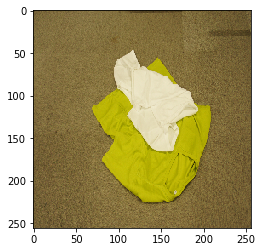

In [15]:
#Read test images  and resize them into (256,256)

#画像データはarray型にする。
import cv2

#pngデータ
image_num = 10
test_images = []


size_tmp = 256, 256


#Resize to (256,256)


for i in range(image_num):
    try:
        #画像読込
        img_name = "./test_image/" + "test" + str(i+1) + ".JPG"
        img = cv2.imread(img_name)
        img = cv2.resize(img,(256,256))
        test_images.append(img)
        
    except:
        print("Error. No such file or directory: " + img_name)




dataset_train = np.array(images)

print("Example of test_image[JPG]")
test_img = test_images[1]
plt.imshow(img[:,:,::-1])
plt.plot()
#print("(データ数, H, W, RGBの3) = ", dataset_train.shapes


In [ ]:
#テスト用imageを取得

from numpy.random import *

flag = 0
while(flag == 0):
    testid = randint(10)
    
    #if(testid != 1 and testid !=24):
    #    flag = 1
test_img_name = "./test_image/test" + str(testid) + ".JPG"
test_img = plt.imread(test_img_name)

#detection
results = model.detect([test_img], verbose=1)

# Visualize Results

r = results[0]
#visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
#                           class_name, r["scores"])

In [ ]:
r

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


# json から情報取得

In [ ]:
#import 
import json
from statistics import mean, median,variance,stdev

shapes = []
json_name = "./image/0_ex1.json"
f = open(json_name)
data = json.load(f)
json_label_num = len(data["shapes"]) #num pf shapes on each image

for i in range(json_label_num):
    label = data["shapes"][i]["label"]
    print("label", i ,". ", label)
    points = np.array(data["shapes"][0]["points"]) #once convert to array to calculate
    x_mean = points[:,0]
    y_mean = points[:,1]
    #s はx_widthとy_widthの大きい方を用いて計算
    x_width = max(points[:,0]) - min(points[:,0])
    y_width = max(points[:,1]) - min(points[:,1])
    if(x_width > y_width):
        size = x_width + 10 #余裕をもたせる
    else: size = y_width + 10
    
    if(label =="tg"):#green Tshirts
        color = (255,0,0) # RED
    elif(label == "tw"): 
        color = (0,0,255) #white Tshirts
    
    else: print("ERROR. the object has no class id like \"tg\"")
